LSTM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
 Predicted=310.494473, Expected=307.970001
 Predicted=308.397601, Expected=306.279999
 Predicted=306.801375, Expected=309.920013
 Predicted=310.672474, Expected=306.869995
 Predicted=307.396617, Expected=317.140015
 Predicted=317.875795, Expected=307.940002
 Predicted=307.692067, Expected=312.559998
 Predicted=312.882166, Expected=304.690002
 Predicted=304.980789, Expected=310.839996
 Predicted=311.346783, Expected=285.570007
 Predicted=285.817940, Expected=295.709991
 Predicted=294.768057, Expected=287.750000
 Predicted=288.243828, Expected=299.950012
 Predicted=300.169663, Expected=290.529999
 Predicted=290.267810, Expected=266.540009
 Predicted=266.813367, Expected=265.649994
 Predicted=265.897531,

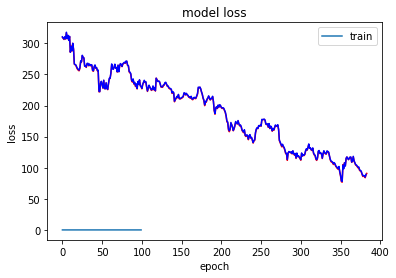

383


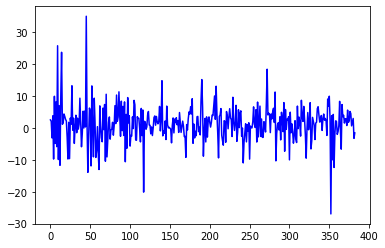

In [1]:
import pandas as pd 
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    history = []
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        history.append(model.history)
        model.reset_states()
    return model,history

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

data = pd.read_csv('BABA.csv')
data = data['Close']
data_ar = data.values
data_ar_stationary = difference(data_ar,1)
supervised = timeseries_to_supervised(data_ar_stationary, 1)
supervised_values = supervised.values
train_data,test_data = supervised_values[0:int(len(data)*0.8)],supervised_values[int(len(data)*0.8):]
scaler, train_scaled, test_scaled = scale(train_data, test_data)
lstm_model,history = fit_lstm(train_scaled, 1, 100, 4)

train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

train_loss=[]
test_loss=[]
for i in range(0,len(history)):
    print(i)
    train_loss.append(history[i].history['loss'])
    # test_loss.append(history[i].history['val_loss'])
    i+=1

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_loss)
# plt.plot(test_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='best')

predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(data_ar, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = data_ar[len(train_data) + i + 1]
    print(' Predicted=%f, Expected=%f' % (yhat, expected))


# report performance
rmse = sqrt(mean_squared_error(data_ar[int(len(data)*0.8)+1:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(data_ar[int(len(data)*0.8):],color='red')
pyplot.plot(predictions,color='blue')
pyplot.show()

diff4 = []
for i in range(len(test_scaled)):
  expected = data_ar[len(train_data) + i + 1]
  diff4.append(predictions[i]-expected)

print(len(diff4))

pyplot.plot(diff4,color='blue')

